In [19]:
import confluent_kafka
import time
import uuid
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
msg_count = 1000
iteration=30
consumer_timings = {}
consumer_messages={}
bootstrap_servers = 'localhost:9092'

In [21]:
def confluent_kafka_consumer_performance(msg_count):
    
    topic = 'confluent-kafka-topic'
    msg_consumed_count = 0
    conf = {'bootstrap.servers': bootstrap_servers,
            'group.id': uuid.uuid1(),
            'session.timeout.ms': 6000,
            'default.topic.config': {
                'auto.offset.reset': 'earliest'
            }
    }

    consumer = confluent_kafka.Consumer(**conf)

    consumer_start = time.time()
    # This is the same as pykafka, subscribing to a topic will start a background thread
    consumer.subscribe([topic])

    while True:
        msg = consumer.poll(1)
        if msg:
            msg_consumed_count += 1
                         
        if msg_consumed_count >= msg_count:
            break
                    
    consumer_timing = time.time() - consumer_start
    consumer.close()    
    return consumer_timing


def calculate_thoughput(timing, n_messages=10000, msg_size=100):
    print("Processed {0} messsages in {1:.2f} seconds".format(n_messages, timing))
    print("{0:.2f} MB/s".format((msg_size * n_messages) / timing / (1024*1024)))
    print("{0:.2f} Msgs/s".format(n_messages / timing))


In [22]:
for i in range(iteration):
    _ = confluent_kafka_consumer_performance(msg_count) # Warm cache
    time_t=confluent_kafka_consumer_performance(msg_count)
    consumer_timings[msg_count] = time_t
    consumer_messages[msg_count]=msg_count/time_t
    msg_count=msg_count+1000
    #calculate_thoughput(consumer_timings['confluent_kafka_consumer'])

In [23]:
total_num_mes=0
for item in consumer_messages:
    total_num_mes=consumer_messages[item] + total_num_mes
avg=total_num_mes/iteration    
print("After Taking avergae number of messages read per second ::",avg)

After Taking avergae number of messages written per second :: 321748.83251705574


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fab544a1ac8>],
      dtype=object)

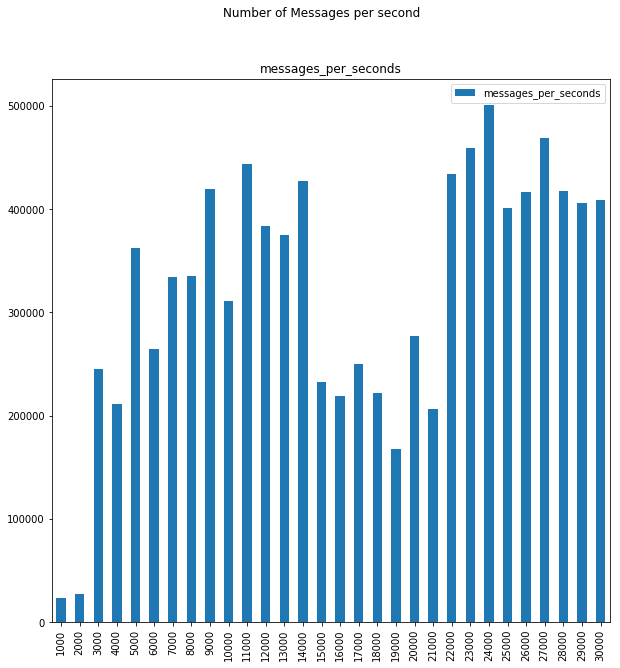

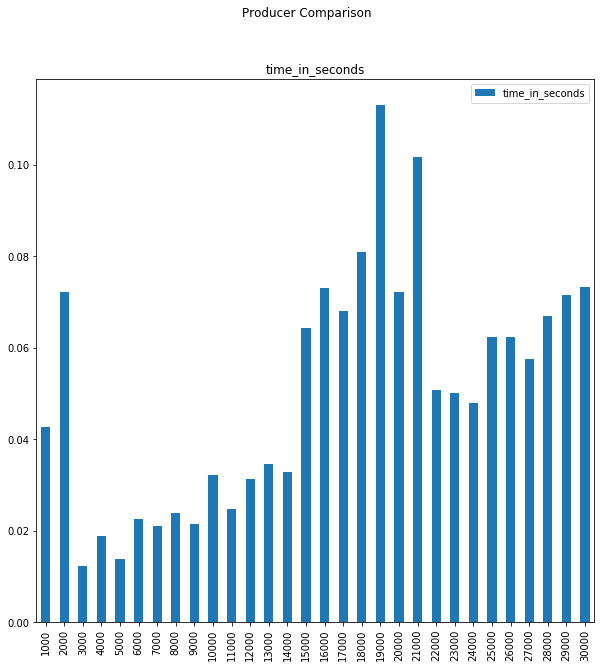

In [24]:
consumer_df = pd.DataFrame.from_dict(consumer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
consumer_df1 = pd.DataFrame.from_dict(consumer_messages, orient='index').rename(columns={0: 'messages_per_seconds'})

consumer_df1.sort_index(inplace=True)
consumer_df1
consumer_df1.plot(kind='bar', subplots=True, figsize=(10, 10), title="Number of Messages per second")

consumer_df.sort_index(inplace=True)
consumer_df
consumer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Producer Comparison")
